In [2]:
import numpy as np
import pandas as pd
import io, os
import nltk, time, re, string, pickle
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn import metrics

In [2]:
import ast 
def get_file():
    with open('dataset/normalisasi.txt') as f:
        data_normalisai = f.read()
    normalization_words = ast.literal_eval(data_normalisai)

    with open('dataset/stopwords.txt') as f:
        data_stopwords = f.read()
        stopwords = ast.literal_eval(data_stopwords)

    return normalization_words, stopwords

normalization_words, stopwords = get_file()

In [3]:
def normalisasi(texts):
    finalText = []
    splitted_text = texts.split()
    for text in splitted_text:
        if text in normalization_words:
            finalText.append(normalization_words[text])
        else:
            finalText.append(text)
      
    return " ".join(finalText)

In [4]:
def hapus_stopword(text):
    stopword_factory = stopwords

    sw_dict = ArrayDictionary(stopword_factory)
    temp = StopWordRemover(sw_dict)

    text = temp.remove(text)
    return text

In [5]:
def hapus_duplikasi_kata(text):
    res = []
    text = text.split()
    for i in text:
        if i in res:
            text.remove(i)
        else:
            res.append(i)
    return " ".join(text)

In [6]:
def stemming(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    text = stemmer.stem(text)
    return text

In [7]:
def case_folding(text):
    text = text.lower()
    # remove space in front of and at the end text
    text = text.strip()
    # remove space
    text = re.sub(r'\s+', ' ', text)
    # remove number
    text = re.sub(r"\d+", " ", text)
    # remove punctuation
    for i in text:
        if i in list(string.punctuation):
            text = text.replace(i, " ")

    return text

In [8]:
def preprocessing_data(opinion):
    opinion = case_folding(opinion)
    opinion = normalisasi(opinion)
    opinion = hapus_stopword(opinion)
    opinion = hapus_duplikasi_kata(opinion)
    opinion = stemming(opinion)
    return opinion

In [3]:
train=pd.read_excel("DataKuesioner_Done.xlsx")
train.head()

,Aspect,Sentiment,Tempat,Opinion
0,Tempat,Positif,4,Karena tempatnya memadai dan antrian teratur
1,Tempat,Negatif,2,lumayan berdesakan dan tdk menerapkan social d...
2,Tempat,Positif,3,terkadang terlalu ramai
3,Tempat,Positif,4,Tempat bersih dan luas
4,Tempat,Positif,4,Tempat vaksinasi sangat layak karena pihak pen...


In [10]:
test=pd.read_excel("app/dataset/DatasetMedsosPlus.xlsx")
test.head()

,Opinion,Aspect,Sentiment
0,Vaksinasi saat ini sudah mudah ditemukan diman...,Informasi,Positif
1,banyak infonya,Informasi,Positif
2,Karena dapat info vaksin hanya dari kenalan yg...,Informasi,Negatif
3,Jd ak puas km ak akhirnya tny ke temenku dan d...,Informasi,Positif
4,Puas krn informasi udh bnyk beredar d twitter ...,Informasi,Positif


In [11]:
# Processed data for CountVectorizer and Save to txt for vocabulary
file_vocab = open("vocabulary_ya3.txt","a")
train_vocab = []
for i,row in train.iterrows():
    preprocessedVocab = preprocessing_data(row['Opinion'])
    train_vocab.append(preprocessedVocab)
file_vocab.write(str(train_vocab))

In [13]:
# Preprocessing Data
X_train_processed=[]
X_test_processed=[]
y_sentiment_train =[]
y_aspect_train =[]
y_sentiment_test=[]
y_aspect_test=[]

for index, row in train.iterrows():
    processedText = preprocessing_data(str(row['Opinion']))
    X_train_processed.append(processedText)
    y_sentiment_train.append(row['Sentiment'])
    y_aspect_train.append(row['Aspect'])

for index, row in test.iterrows():
    processedText = preprocessing_data(str(row['Opinion']))
    X_test_processed.append(processedText)
    y_sentiment_test.append(row['Sentiment'])
    y_aspect_test.append(row['Aspect'])

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(lowercase='false')
count_vect.fit(train_vocab)

CountVectorizer(lowercase='false')

In [21]:
X_train_vect = count_vect.transform(X_train_processed)
X_train_vect = X_train_vect.toarray().astype(float)
X_train_vect = np.array(X_train_vect, dtype='float64')

In [22]:
X_test_vect = count_vect.transform(X_test_processed)
X_test_vect = X_test_vect.toarray().astype(float)
X_test_vect = np.array(X_test_vect, dtype='float64')

# LGBM

In [16]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn import metrics

In [92]:
LGBMmodel = lgb.LGBMClassifier()
LGBMmodel.fit(X_train_vect, y_sentiment_train)

LGBMClassifier(boosting_type='dart', learning_rate=0.5, max_depth=4,
               num_leaves=8)

In [93]:
y_pred=LGBMmodel.predict(X_test_vect)

print("Accuracy:",metrics.accuracy_score(y_sentiment_test, y_pred))
print("Precision:",metrics.precision_score(y_sentiment_test, y_pred, average='micro'))
print("Recall:",metrics.recall_score(y_sentiment_test, y_pred, average='micro')) #will return the total ratio of tp/(tp + fp)
print("F-1Score:",metrics.f1_score(y_sentiment_test, y_pred, average='micro'))
print("Precision per class:",metrics.precision_score(y_sentiment_test, y_pred, average=None))

Accuracy: 0.8100358422939068
Precision: 0.749370543803092
Recall: 0.6855791962174941
F-1Score: 0.7059361638659639
Precision per class: [0.65934066 0.83940043]


In [125]:
# Aspect
LGBAspectMmodel = lgb.LGBMClassifier(boosting_type='dart', learning_rate=0.9, max_depth=8,num_leaves=4)
LGBAspectMmodel.fit(X_train_vect, y_aspect_train)

LGBMClassifier(boosting_type='dart', learning_rate=0.9, max_depth=8,
               num_leaves=4)

In [126]:
y_aspect_pred=LGBAspectMmodel.predict(X_test_vect)

print("Accuracy:",metrics.accuracy_score(y_aspect_test, y_aspect_pred))
print("Precision:",metrics.precision_score(y_aspect_test, y_aspect_pred, average='micro'))
print("Recall:",metrics.recall_score(y_aspect_test, y_aspect_pred, average='micro')) #will return the total ratio of tp/(tp + fp)
print("F-1Score:",metrics.f1_score(y_aspect_test, y_aspect_pred, average='micro'))
print("Precision per class:",metrics.precision_score(y_aspect_test, y_aspect_pred, average=None))

Accuracy: 0.7956989247311828
Precision: 0.8035896297622609
Recall: 0.7951188577624306
F-1Score: 0.7971037458642136
Precision per class: [0.95145631 0.69105691 0.91489362 0.67592593 0.78461538]


# NB

In [22]:
#Import svm model
from sklearn.naive_bayes import MultinomialNB
NBModel = MultinomialNB()
NBModel.fit(X_train_vect, y_sentiment_train)

MultinomialNB()

In [23]:
#Create a svm Classifier (Aspect)
NBAspectModel = MultinomialNB()
NBAspectModel.fit(X_train_vect, y_aspect_train)

MultinomialNB()

In [24]:
#Predict the response for test dataset
y_pred = NBModel.predict(X_test_vect)
y_aspect_pred = NBAspectModel.predict(X_test_vect)

In [25]:
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_sentiment_test, y_pred))
print("Precision:",metrics.precision_score(y_sentiment_test, y_pred, average='micro'))
print("Recall:",metrics.recall_score(y_sentiment_test, y_pred, average='micro')) #will return the total ratio of tp/(tp + fp)
print("F-1Score:",metrics.f1_score(y_sentiment_test, y_pred, average='micro'))
print("Precision per class:",metrics.precision_score(y_sentiment_test, y_pred, average=None))

Accuracy: 0.8297491039426523
Precision: 0.7816558441558441
Recall: 0.7187549251379038
F-1Score: 0.7406999779881136
Precision per class: [0.70833333 0.85497835]


In [26]:
# Aspect
print("Accuracy:",metrics.accuracy_score(y_aspect_test, y_aspect_pred))
print("Precision:",metrics.precision_score(y_aspect_test, y_aspect_pred, average='micro'))
print("Recall:",metrics.recall_score(y_aspect_test, y_aspect_pred, average='micro'))
print("F-1Score:",metrics.f1_score(y_aspect_test, y_aspect_pred, average='micro'))

Accuracy: 0.8207885304659498
Precision: 0.8289476395069666
Recall: 0.8207594442021897
F-1Score: 0.8221614121000433


# RF

In [40]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier
RFModel=RandomForestClassifier(max_depth=60, min_samples_split=3, n_estimators=200)
RFModel.fit(X_train_vect,y_sentiment_train)

RandomForestClassifier(max_depth=60, min_samples_split=3, n_estimators=200)

In [17]:
#Create a Aspect Classifier
RFAspectModel=RandomForestClassifier(max_depth=50, max_features='log2',min_samples_split=4, n_estimators=1000)
RFAspectModel.fit(X_train_vect,y_aspect_train)

RandomForestClassifier(max_depth=50, max_features='log2', min_samples_split=4,
                       n_estimators=1000)

In [41]:
#Predict the response for test dataset
y_pred=RFModel.predict(X_test_vect)
y_aspect_pred=RFAspectModel.predict(X_test_vect)

In [42]:
print("Accuracy:",metrics.accuracy_score(y_sentiment_test, y_pred))
print("Precision:",metrics.precision_score(y_sentiment_test, y_pred, average='micro'))
print("Recall:",metrics.recall_score(y_sentiment_test, y_pred, average='micro')) #will return the total ratio of tp/(tp + fp)
print("F-1Score:",metrics.f1_score(y_sentiment_test, y_pred, average='micro'))
print("Precision per class:",metrics.precision_score(y_sentiment_test, y_pred, average=None))

Accuracy: 0.8422939068100358
Precision: 0.8178820545339252
Recall: 0.7194641449960599
F-1Score: 0.7491673647861711
Precision per class: [0.78313253 0.85263158]


In [62]:
print(metrics.confusion_matrix(y_sentiment_test,y_pred))
tn, fp, fn, tp = metrics.confusion_matrix(y_sentiment_test, y_pred).ravel()
(tn, fp, fn, tp)

[[ 77  58]
 [ 28 395]]


(77, 58, 28, 395)

In [121]:
# Aspect
print("Accuracy:",metrics.accuracy_score(y_aspect_test, y_aspect_pred))
print("Precision:",metrics.precision_score(y_aspect_test, y_aspect_pred, average='micro'))
print("Recall:",metrics.recall_score(y_aspect_test, y_aspect_pred, average='micro')) #will return the total ratio of tp/(tp + fp)
print("F-1Score:",metrics.f1_score(y_aspect_test, y_aspect_pred, average='micro'))
print("Precision per class:",metrics.precision_score(y_aspect_test, y_aspect_pred, average=None)) #will return the precision scores for each class
# https://scikit-learn.org/stable/modules/model_evaluation.html#multiclass-and-multilabel-classification

Accuracy: 0.8243727598566308
Precision: 0.8334173576932162
Recall: 0.8240168766425853
F-1Score: 0.8255213071700489
Precision per class: [0.96969697 0.72727273 0.9375     0.75247525 0.78014184]


# SVM

In [32]:
#Import svm model
from sklearn import svm
SVMmodel = svm.SVC(probability=True)

#Train the model using the training sets
SVMmodel.fit(X_train_vect, y_sentiment_train)

SVC(probability=True)

In [33]:
#Create a svm Classifier (Aspect)
SVMAspectModel = svm.SVC(probability=True)
SVMAspectModel.fit(X_train_vect, y_aspect_train)

SVC(probability=True)

In [34]:
#Predict the response for test dataset
y_pred = SVMmodel.predict(X_test_vect)
y_aspect_pred_svm = SVMAspectModel.predict(X_test_vect)

In [35]:
print("Accuracy:",metrics.accuracy_score(y_sentiment_test, y_pred))
print("Precision:",metrics.precision_score(y_sentiment_test, y_pred, average='micro'))
print("Recall:",metrics.recall_score(y_sentiment_test, y_pred, average='micro')) #will return the total ratio of tp/(tp + fp)
print("F-1Score:",metrics.f1_score(y_sentiment_test, y_pred, average='micro'))
print("Precision per class:",metrics.precision_score(y_sentiment_test, y_pred, average=None))

Accuracy: 0.8136200716845878
Precision: 0.7875119569878286
Recall: 0.6526398739164696
F-1Score: 0.6781721384205857
Precision per class: [0.75409836 0.82092555]


In [36]:
# Aspect
print("Accuracy:",metrics.accuracy_score(y_aspect_test, y_aspect_pred_svm))
print("Precision:",metrics.precision_score(y_aspect_test, y_aspect_pred_svm, average='micro'))
print("Recall:",metrics.recall_score(y_aspect_test, y_aspect_pred_svm, average='micro')) #will return the total ratio of tp/(tp + fp)
print("F-1Score:",metrics.f1_score(y_aspect_test, y_aspect_pred_svm, average='micro'))
print("Precision per class:",metrics.precision_score(y_aspect_test, y_aspect_pred_svm, average=None))

Accuracy: 0.8064516129032258
Precision: 0.8160735783114299
Recall: 0.8051231994908722
F-1Score: 0.8078466622230509
Precision per class: [0.93636364 0.74782609 0.92045455 0.62698413 0.8487395 ]


# SAVE MODEL

In [ ]:
import pickle

In [122]:
# RF
filename = 'rf_aspect_K.sav'
pickle.dump(RFAspectModel, open(filename, 'wb'))

In [20]:
filename_sent = 'rf_sentiment_K.sav'
pickle.dump(RFModel, open(filename_sent, 'wb'))

In [59]:
# NB
filename = 'nb_aspect_K.sav'
pickle.dump(NBAspectModel, open(filename, 'wb'))

In [60]:
filename_sent = 'nb_sentiment_K.sav'
pickle.dump(NBModel, open(filename_sent, 'wb'))

In [205]:
# SVM
filename = 'svm_aspect_K_2.sav'
pickle.dump(SVMAspectModel, open(filename, 'wb'))

In [209]:
filename_sent = 'svm_sentiment_K_2.sav'
pickle.dump(SVMmodel, open(filename_sent, 'wb'))

In [128]:
LGBAspectMmodel

LGBMClassifier(boosting_type='dart', learning_rate=0.9, max_depth=8,
               num_leaves=4)

In [130]:
# LGBM
filename = 'lgbm_aspect_K_2.sav'
pickle.dump(LGBAspectMmodel, open(filename, 'wb'))

In [66]:
filename_sent = 'lgbm_sentiment_K.sav'
pickle.dump(LGBMmodel, open(filename_sent, 'wb'))

# Testing SAV Model

In [71]:
data=pd.read_excel("app/dataset/DatasetMedsosPlus.xlsx")
data.head()

,Opinion,Aspect,Sentiment
0,Vaksinasi saat ini sudah mudah ditemukan diman...,Informasi,Positif
1,banyak infonya,Informasi,Positif
2,Karena dapat info vaksin hanya dari kenalan yg...,Informasi,Negatif
3,Jd ak puas km ak akhirnya tny ke temenku dan d...,Informasi,Positif
4,Puas krn informasi udh bnyk beredar d twitter ...,Informasi,Positif


In [72]:
opinion = data.iloc[:, 0]
aspect = data.iloc[:, 1]
sentiment = data.iloc[:, 2]

In [18]:
X_processed = X_test_processed

In [21]:
X_processed = [preprocessing_data(row) for row in opinion]

In [19]:
with open("vocabulary_ya3.txt") as f:
      vocabulary = f.read()
vocabulary = [vocabulary]

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
count_vect.fit(vocabulary)
# count_vect.vocabulary_

CountVectorizer()

In [40]:
#Kuesioner
# aspect_model = pickle.load(open('app/model/model_gridsearch_2/lgbm_aspect_K_2.sav','rb'))
# sentiment_model = pickle.load(open('app/model/model_gridsearch_2/lgbm_sentiment_K.sav','rb'))

# aspect_model = pickle.load(open('app/model/model_gridsearch_2/rf_aspect_K_2.sav','rb'))
## sentiment_model = pickle.load(open('app/model/model_baru_2/rf_sentiment_K.sav','rb'))
# sentiment_model = pickle.load(open('app/model/model_gridsearch_2/rf_sentiment_K.sav','rb'))

# aspect_model = pickle.load(open('app/model/model_gridsearch_2/svm_aspect_K.sav','rb'))
# sentiment_model = pickle.load(open('app/model/model_gridsearch_2/svm_sentiment_K.sav','rb'))

aspect_model = pickle.load(open('app/model/model_baru/nb_aspect_K.sav','rb'))
sentiment_model = pickle.load(open('app/model/model_baru/nb_sentiment_K.sav','rb'))

In [41]:
result_aspect = []
result_sentiment = []
for row in X_processed:
    row = [row]
    new_vect = count_vect.transform(row)
    new_vect = new_vect.toarray().astype(float)
    new_vect = np.array(new_vect, dtype='float64')
    result_aspect.extend(aspect_model.predict(new_vect))
    result_sentiment.extend(sentiment_model.predict(new_vect))

In [42]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_sentiment_test, result_sentiment))
print("Precision:",metrics.precision_score(y_sentiment_test, result_sentiment, average='macro'))
print("Recall:",metrics.recall_score(y_sentiment_test, result_sentiment, average='macro'))
print("F-1Score:",metrics.f1_score(y_sentiment_test, result_sentiment, average='macro'))
print("Precision per class:",metrics.precision_score(y_sentiment_test, result_sentiment, average=None))
print("Recall per class:",metrics.recall_score(y_sentiment_test, result_sentiment, average=None))

print("Precision class Positif:",metrics.precision_score(y_sentiment_test, result_sentiment, pos_label='Positif'))
print("Recall class Positif:",metrics.recall_score(y_sentiment_test, result_sentiment, pos_label='Positif'))

print(metrics.confusion_matrix(y_sentiment_test,result_sentiment, labels=["Positif"]))
print(metrics.confusion_matrix(y_sentiment_test,result_sentiment, labels=["Negatif"]))
tn, fp, fn, tp = metrics.confusion_matrix(y_sentiment_test, result_sentiment).ravel()
(tn, fp, fn, tp)

Accuracy: 0.8333333333333334
Precision: 0.7879464285714286
Recall: 0.7236406619385343
F-1Score: 0.7461589258199428
Precision per class: [0.71875    0.85714286]
Recall per class: [0.51111111 0.93617021]
Precision class Positif: 0.8571428571428571
Recall class Positif: 0.9361702127659575
[[396]]
[[69]]


(69, 66, 27, 396)

In [130]:
# Aspect
print("Accuracy:",metrics.accuracy_score(y_aspect_test, result_aspect))
print("Precision:",metrics.precision_score(y_aspect_test, result_aspect, average='macro'))
print("Recall:",metrics.recall_score(y_aspect_test, result_aspect, average='macro'))
print("F-1Score:",metrics.f1_score(y_aspect_test, result_aspect, average='macro'))
print("Precision per class:",metrics.precision_score(y_aspect_test, result_aspect, average=None))
print("Recall per class:",metrics.recall_score(y_aspect_test, result_aspect, average=None))
print(confusion_matrix(y_aspect_test,result_aspect))

Accuracy: 0.7956989247311828
Precision: 0.8035896297622609
Recall: 0.7951188577624306
F-1Score: 0.7971037458642136
Precision per class: [0.95145631 0.69105691 0.91489362 0.67592593 0.78461538]
Recall per class: [0.80327869 0.79439252 0.86       0.70192308 0.816     ]
[[ 98   6   4   5   9]
 [  1  85   1  18   2]
 [  0   1  86   4   9]
 [  1  21   1  73   8]
 [  3  10   2   8 102]]


In [18]:
X_test_vect = count_vect.transform(X_test_processed)
X_test_vect = X_test_vect.toarray().astype(float)
X_test_vect = np.array(X_test_vect, dtype='float64')

Random Prediction: ROC AUC=0.500
Random Forest: ROC AUC=0.911


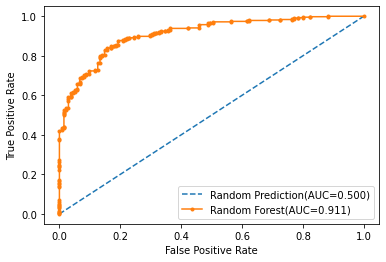

In [24]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

y_test = []
for row in y_sentiment_test:
    if row == 'Positif':
        y_test.append(1)
    else:
        y_test.append(0)

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs)
print('Random Prediction: ROC AUC=%.3f' % (ns_auc))
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Random Prediction(AUC=%.3f)' % (ns_auc))

# fit a model
probs = sentiment_model.predict_proba(X_test_vect)
probs = probs[:, 1]
roc_auc_score = roc_auc_score(y_test, probs)
print('Random Forest: ROC AUC=%.3f' % (roc_auc_score))

# calculate roc curves
fpr, tpr, _ = roc_curve(y_test, probs)
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.', label='Random Forest(AUC=%.3f)' % (roc_auc_score))
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend(loc='lower right')
# show the plot
plt.show()

# TUNING

In [45]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
import lightgbm as lgb

# Sentiment

In [163]:
param_grid = {'C': [2], 'gamma': [10,0.1],'kernel': ['rbf']}

In [164]:
grid = GridSearchCV(svm.SVC(),param_grid,refit=True,verbose=2, cv=5)
grid.fit(X_train_vect,y_sentiment_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END ..........................C=2, gamma=10, kernel=rbf; total time=   3.4s
[CV] END ..........................C=2, gamma=10, kernel=rbf; total time=   3.6s
[CV] END ..........................C=2, gamma=10, kernel=rbf; total time=   3.9s
[CV] END ..........................C=2, gamma=10, kernel=rbf; total time=   3.7s
[CV] END ..........................C=2, gamma=10, kernel=rbf; total time=   3.7s
[CV] END .........................C=2, gamma=0.1, kernel=rbf; total time=   1.8s
[CV] END .........................C=2, gamma=0.1, kernel=rbf; total time=   1.8s
[CV] END .........................C=2, gamma=0.1, kernel=rbf; total time=   1.7s
[CV] END .........................C=2, gamma=0.1, kernel=rbf; total time=   1.8s
[CV] END .........................C=2, gamma=0.1, kernel=rbf; total time=   1.9s


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [2], 'gamma': [10, 0.1], 'kernel': ['rbf']},
             verbose=2)

In [165]:
print(grid.best_estimator_)

SVC(C=2, gamma=10)


In [73]:
df = pd.DataFrame(grid.cv_results_)
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.044330,0.038435,0.178256,0.047624,0.1,10,linear,"{'C': 0.1, 'gamma': 10, 'kernel': 'linear'}",0.802698,0.841484,0.768971,0.807757,0.841484,0.812479,0.027179,24
1,2.173130,0.079446,0.828246,0.033444,0.1,10,rbf,"{'C': 0.1, 'gamma': 10, 'kernel': 'rbf'}",0.836425,0.836425,0.836425,0.834739,0.834739,0.835750,0.000826,7
2,0.874195,0.064951,0.115600,0.012494,0.1,10,sigmoid,"{'C': 0.1, 'gamma': 10, 'kernel': 'sigmoid'}",0.774030,0.826307,0.785835,0.799325,0.826307,0.802361,0.021127,40
3,1.009356,0.021549,0.149964,0.007653,0.1,1,linear,"{'C': 0.1, 'gamma': 1, 'kernel': 'linear'}",0.802698,0.841484,0.768971,0.807757,0.841484,0.812479,0.027179,24
4,2.028241,0.145410,0.727952,0.021190,0.1,1,rbf,"{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}",0.836425,0.836425,0.836425,0.834739,0.834739,0.835750,0.000826,7
5,1.288571,0.041682,0.165245,0.018937,0.1,1,sigmoid,"{'C': 0.1, 'gamma': 1, 'kernel': 'sigmoid'}",0.795953,0.826307,0.795953,0.799325,0.834739,0.810455,0.016646,29
6,1.119804,0.037196,0.164018,0.019792,0.1,0.1,linear,"{'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}",0.802698,0.841484,0.768971,0.807757,0.841484,0.812479,0.027179,24
7,1.304158,0.031457,0.429232,0.033513,0.1,0.1,rbf,"{'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}",0.836425,0.836425,0.836425,0.834739,0.834739,0.835750,0.000826,7
8,1.113969,0.027425,0.160255,0.011104,0.1,0.1,sigmoid,"{'C': 0.1, 'gamma': 0.1, 'kernel': 'sigmoid'}",0.836425,0.836425,0.836425,0.834739,0.834739,0.835750,0.000826,7
9,1.158436,0.043920,0.192918,0.017428,0.1,0.01,linear,"{'C': 0.1, 'gamma': 0.01, 'kernel': 'linear'}",0.802698,0.841484,0.768971,0.807757,0.841484,0.812479,0.027179,24


In [166]:
grid_predictions = grid.predict(X_test_vect)

print(confusion_matrix(y_sentiment_test,grid_predictions))
print(classification_report(y_sentiment_test,grid_predictions))

[[  4 131]
 [  2 421]]
              precision    recall  f1-score   support

     Negatif       0.67      0.03      0.06       135
     Positif       0.76      1.00      0.86       423

    accuracy                           0.76       558
   macro avg       0.71      0.51      0.46       558
weighted avg       0.74      0.76      0.67       558



In [167]:
print("Accuracy:",metrics.accuracy_score(y_sentiment_test, grid_predictions))
print("Precision:",metrics.precision_score(y_sentiment_test, grid_predictions, pos_label='Negatif'))
print("Recall:",metrics.recall_score(y_sentiment_test, grid_predictions, pos_label='Negatif'))
print("F-1Score:",metrics.f1_score(y_sentiment_test, grid_predictions, pos_label='Negatif'))

Accuracy: 0.7616487455197133
Precision: 0.6666666666666666
Recall: 0.02962962962962963
F-1Score: 0.05673758865248227


In [268]:
filename = 'svm_sentiment_K.sav'
pickle.dump(grid.best_estimator_, open(filename, 'wb'))

In [24]:
param_grid = {'boosting_type': ['dart'],
 'learning_rate': [0.01,0.03,0.05,0.07,0.1,0.3,0.5,0.7,0.9],
 'max_depth': [4,5,8,10,12],
 'num_leaves': [8, 12,50,60,80,100],
 'n_estimators': [200, 600, 1000,3000]}

In [25]:
grid_lgbm_sentiment = GridSearchCV(lgb.LGBMClassifier(),param_grid,refit=True,verbose=2, cv = 10)
grid_lgbm_sentiment.fit(X_train_vect,y_sentiment_train)

Fitting 10 folds for each of 400 candidates, totalling 4000 fits
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=4, n_estimators=200, num_leaves=8; total time=   0.0s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=4, n_estimators=200, num_leaves=8; total time=   0.1s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=4, n_estimators=200, num_leaves=8; total time=   0.1s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=4, n_estimators=200, num_leaves=8; total time=   0.1s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=4, n_estimators=200, num_leaves=8; total time=   0.1s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=4, n_estimators=200, num_leaves=8; total time=   0.1s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=4, n_estimators=200, num_leaves=8; total time=   0.1s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=4, n_estimators=200, num_leaves=8; total time=   0.1s
[CV] END boosting_type=dart, le

[CV] END boosting_type=dart, learning_rate=0.05, max_depth=4, n_estimators=600, num_leaves=50; total time=   0.6s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=4, n_estimators=600, num_leaves=50; total time=   0.6s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=4, n_estimators=600, num_leaves=50; total time=   0.7s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=4, n_estimators=600, num_leaves=50; total time=   0.7s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=4, n_estimators=600, num_leaves=50; total time=   0.6s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=4, n_estimators=600, num_leaves=50; total time=   0.7s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=4, n_estimators=600, num_leaves=50; total time=   0.6s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=4, n_estimators=600, num_leaves=50; total time=   0.6s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=4, n_estimators=600, num_leav

[CV] END boosting_type=dart, learning_rate=0.05, max_depth=4, n_estimators=1000, num_leaves=80; total time=   1.2s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=4, n_estimators=1000, num_leaves=80; total time=   1.3s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=4, n_estimators=1000, num_leaves=80; total time=   1.4s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=4, n_estimators=1000, num_leaves=80; total time=   1.3s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=4, n_estimators=1000, num_leaves=80; total time=   1.3s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=4, n_estimators=1000, num_leaves=80; total time=   1.4s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=4, n_estimators=3000, num_leaves=8; total time=   4.2s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=4, n_estimators=3000, num_leaves=8; total time=   4.5s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=4, n_estimators=3000, n

[CV] END boosting_type=dart, learning_rate=0.05, max_depth=5, n_estimators=200, num_leaves=12; total time=   0.1s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=5, n_estimators=200, num_leaves=12; total time=   0.1s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=5, n_estimators=200, num_leaves=12; total time=   0.2s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=5, n_estimators=200, num_leaves=12; total time=   0.1s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=5, n_estimators=200, num_leaves=50; total time=   0.2s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=5, n_estimators=200, num_leaves=50; total time=   0.2s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=5, n_estimators=200, num_leaves=50; total time=   0.2s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=5, n_estimators=200, num_leaves=50; total time=   0.2s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=5, n_estimators=200, num_leav

[CV] END boosting_type=dart, learning_rate=0.05, max_depth=5, n_estimators=600, num_leaves=60; total time=   0.8s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=5, n_estimators=600, num_leaves=60; total time=   0.9s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=5, n_estimators=600, num_leaves=80; total time=   0.8s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=5, n_estimators=600, num_leaves=80; total time=   0.8s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=5, n_estimators=600, num_leaves=80; total time=   0.9s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=5, n_estimators=600, num_leaves=80; total time=   1.2s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=5, n_estimators=600, num_leaves=80; total time=   1.3s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=5, n_estimators=600, num_leaves=80; total time=   1.3s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=5, n_estimators=600, num_leav

[CV] END boosting_type=dart, learning_rate=0.05, max_depth=5, n_estimators=3000, num_leaves=12; total time=   6.0s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=5, n_estimators=3000, num_leaves=12; total time=   5.8s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=5, n_estimators=3000, num_leaves=12; total time=   5.8s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=5, n_estimators=3000, num_leaves=12; total time=   6.3s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=5, n_estimators=3000, num_leaves=12; total time=   5.6s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=5, n_estimators=3000, num_leaves=12; total time=   5.8s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=5, n_estimators=3000, num_leaves=12; total time=   6.2s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=5, n_estimators=3000, num_leaves=12; total time=   5.8s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=5, n_estimators=3000,

[CV] END boosting_type=dart, learning_rate=0.05, max_depth=8, n_estimators=200, num_leaves=60; total time=   0.3s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=8, n_estimators=200, num_leaves=60; total time=   0.3s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=8, n_estimators=200, num_leaves=60; total time=   0.2s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=8, n_estimators=200, num_leaves=60; total time=   0.3s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=8, n_estimators=200, num_leaves=60; total time=   0.3s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=8, n_estimators=200, num_leaves=60; total time=   0.3s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=8, n_estimators=200, num_leaves=60; total time=   0.2s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=8, n_estimators=200, num_leaves=60; total time=   0.3s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=8, n_estimators=200, num_leav

[CV] END boosting_type=dart, learning_rate=0.05, max_depth=8, n_estimators=1000, num_leaves=8; total time=   1.5s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=8, n_estimators=1000, num_leaves=8; total time=   1.4s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=8, n_estimators=1000, num_leaves=8; total time=   1.6s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=8, n_estimators=1000, num_leaves=8; total time=   1.6s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=8, n_estimators=1000, num_leaves=8; total time=   1.4s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=8, n_estimators=1000, num_leaves=8; total time=   1.6s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=8, n_estimators=1000, num_leaves=12; total time=   2.1s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=8, n_estimators=1000, num_leaves=12; total time=   2.1s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=8, n_estimators=1000, num_l

[CV] END boosting_type=dart, learning_rate=0.05, max_depth=8, n_estimators=3000, num_leaves=50; total time=   9.4s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=8, n_estimators=3000, num_leaves=50; total time=   9.6s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=8, n_estimators=3000, num_leaves=50; total time=   9.6s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=8, n_estimators=3000, num_leaves=50; total time=   9.9s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=8, n_estimators=3000, num_leaves=60; total time=   9.3s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=8, n_estimators=3000, num_leaves=60; total time=   8.9s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=8, n_estimators=3000, num_leaves=60; total time=  10.5s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=8, n_estimators=3000, num_leaves=60; total time=  10.3s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=8, n_estimators=3000,

[CV] END boosting_type=dart, learning_rate=0.05, max_depth=10, n_estimators=200, num_leaves=80; total time=   0.3s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=10, n_estimators=200, num_leaves=80; total time=   0.3s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=10, n_estimators=600, num_leaves=8; total time=   0.7s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=10, n_estimators=600, num_leaves=8; total time=   0.7s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=10, n_estimators=600, num_leaves=8; total time=   0.7s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=10, n_estimators=600, num_leaves=8; total time=   0.8s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=10, n_estimators=600, num_leaves=8; total time=   0.7s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=10, n_estimators=600, num_leaves=8; total time=   0.8s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=10, n_estimators=600, num_l

[CV] END boosting_type=dart, learning_rate=0.05, max_depth=10, n_estimators=1000, num_leaves=50; total time=   3.3s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=10, n_estimators=1000, num_leaves=50; total time=   3.2s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=10, n_estimators=1000, num_leaves=50; total time=   3.2s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=10, n_estimators=1000, num_leaves=50; total time=   3.3s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=10, n_estimators=1000, num_leaves=50; total time=   3.0s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=10, n_estimators=1000, num_leaves=50; total time=   3.1s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=10, n_estimators=1000, num_leaves=50; total time=   3.4s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=10, n_estimators=1000, num_leaves=50; total time=   3.3s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=10, n_estimat

[CV] END boosting_type=dart, learning_rate=0.05, max_depth=10, n_estimators=3000, num_leaves=80; total time=  12.2s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=10, n_estimators=3000, num_leaves=80; total time=  11.5s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=10, n_estimators=3000, num_leaves=80; total time=  11.0s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=10, n_estimators=3000, num_leaves=80; total time=  11.0s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=10, n_estimators=3000, num_leaves=80; total time=  11.6s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=10, n_estimators=3000, num_leaves=80; total time=  11.9s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=10, n_estimators=3000, num_leaves=80; total time=  11.6s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=10, n_estimators=3000, num_leaves=80; total time=  11.2s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=10, n_estimat

[CV] END boosting_type=dart, learning_rate=0.07, max_depth=4, n_estimators=600, num_leaves=12; total time=   0.7s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=4, n_estimators=600, num_leaves=12; total time=   0.7s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=4, n_estimators=600, num_leaves=12; total time=   0.7s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=4, n_estimators=600, num_leaves=12; total time=   0.8s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=4, n_estimators=600, num_leaves=12; total time=   1.0s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=4, n_estimators=600, num_leaves=12; total time=   0.7s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=4, n_estimators=600, num_leaves=12; total time=   0.7s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=4, n_estimators=600, num_leaves=50; total time=   0.6s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=4, n_estimators=600, num_leav

[CV] END boosting_type=dart, learning_rate=0.07, max_depth=4, n_estimators=1000, num_leaves=60; total time=   1.4s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=4, n_estimators=1000, num_leaves=60; total time=   1.3s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=4, n_estimators=1000, num_leaves=60; total time=   1.4s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=4, n_estimators=1000, num_leaves=60; total time=   1.4s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=4, n_estimators=1000, num_leaves=60; total time=   1.4s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=4, n_estimators=1000, num_leaves=80; total time=   1.4s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=4, n_estimators=1000, num_leaves=80; total time=   1.3s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=4, n_estimators=1000, num_leaves=80; total time=   1.4s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=4, n_estimators=1000,

[CV] END boosting_type=dart, learning_rate=0.07, max_depth=5, n_estimators=200, num_leaves=8; total time=   0.1s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=5, n_estimators=200, num_leaves=8; total time=   0.1s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=5, n_estimators=200, num_leaves=8; total time=   0.1s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=5, n_estimators=200, num_leaves=12; total time=   0.1s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=5, n_estimators=200, num_leaves=12; total time=   0.1s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=5, n_estimators=200, num_leaves=12; total time=   0.1s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=5, n_estimators=200, num_leaves=12; total time=   0.1s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=5, n_estimators=200, num_leaves=12; total time=   0.1s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=5, n_estimators=200, num_leaves=

[CV] END boosting_type=dart, learning_rate=0.07, max_depth=5, n_estimators=600, num_leaves=50; total time=   0.8s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=5, n_estimators=600, num_leaves=60; total time=   0.8s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=5, n_estimators=600, num_leaves=60; total time=   0.9s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=5, n_estimators=600, num_leaves=60; total time=   0.8s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=5, n_estimators=600, num_leaves=60; total time=   0.8s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=5, n_estimators=600, num_leaves=60; total time=   0.8s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=5, n_estimators=600, num_leaves=60; total time=   0.8s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=5, n_estimators=600, num_leaves=60; total time=   0.8s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=5, n_estimators=600, num_leav

[CV] END boosting_type=dart, learning_rate=0.07, max_depth=5, n_estimators=3000, num_leaves=8; total time=   4.7s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=5, n_estimators=3000, num_leaves=8; total time=   4.9s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=5, n_estimators=3000, num_leaves=8; total time=   5.6s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=5, n_estimators=3000, num_leaves=8; total time=   5.8s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=5, n_estimators=3000, num_leaves=8; total time=   5.2s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=5, n_estimators=3000, num_leaves=8; total time=   5.3s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=5, n_estimators=3000, num_leaves=8; total time=   5.0s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=5, n_estimators=3000, num_leaves=8; total time=   4.7s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=5, n_estimators=3000, num_lea

[CV] END boosting_type=dart, learning_rate=0.07, max_depth=8, n_estimators=200, num_leaves=50; total time=   0.3s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=8, n_estimators=200, num_leaves=50; total time=   0.2s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=8, n_estimators=200, num_leaves=50; total time=   0.2s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=8, n_estimators=200, num_leaves=50; total time=   0.3s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=8, n_estimators=200, num_leaves=50; total time=   0.3s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=8, n_estimators=200, num_leaves=50; total time=   0.2s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=8, n_estimators=200, num_leaves=50; total time=   0.3s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=8, n_estimators=200, num_leaves=60; total time=   0.2s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=8, n_estimators=200, num_leav

[CV] END boosting_type=dart, learning_rate=0.07, max_depth=8, n_estimators=600, num_leaves=80; total time=   1.3s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=8, n_estimators=600, num_leaves=80; total time=   1.3s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=8, n_estimators=600, num_leaves=80; total time=   1.3s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=8, n_estimators=600, num_leaves=80; total time=   1.3s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=8, n_estimators=600, num_leaves=80; total time=   1.4s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=8, n_estimators=1000, num_leaves=8; total time=   1.5s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=8, n_estimators=1000, num_leaves=8; total time=   1.8s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=8, n_estimators=1000, num_leaves=8; total time=   1.5s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=8, n_estimators=1000, num_lea

[CV] END boosting_type=dart, learning_rate=0.07, max_depth=8, n_estimators=3000, num_leaves=12; total time=   7.2s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=8, n_estimators=3000, num_leaves=12; total time=   8.1s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=8, n_estimators=3000, num_leaves=12; total time=   8.6s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=8, n_estimators=3000, num_leaves=50; total time=   9.1s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=8, n_estimators=3000, num_leaves=50; total time=   8.7s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=8, n_estimators=3000, num_leaves=50; total time=   9.2s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=8, n_estimators=3000, num_leaves=50; total time=   9.4s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=8, n_estimators=3000, num_leaves=50; total time=   8.9s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=8, n_estimators=3000,

[CV] END boosting_type=dart, learning_rate=0.07, max_depth=10, n_estimators=200, num_leaves=60; total time=   0.3s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=10, n_estimators=200, num_leaves=80; total time=   0.3s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=10, n_estimators=200, num_leaves=80; total time=   0.3s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=10, n_estimators=200, num_leaves=80; total time=   0.3s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=10, n_estimators=200, num_leaves=80; total time=   0.3s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=10, n_estimators=200, num_leaves=80; total time=   0.3s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=10, n_estimators=200, num_leaves=80; total time=   0.3s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=10, n_estimators=200, num_leaves=80; total time=   0.3s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=10, n_estimators=200,

[CV] END boosting_type=dart, learning_rate=0.07, max_depth=10, n_estimators=1000, num_leaves=12; total time=   2.2s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=10, n_estimators=1000, num_leaves=12; total time=   2.3s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=10, n_estimators=1000, num_leaves=12; total time=   2.3s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=10, n_estimators=1000, num_leaves=12; total time=   2.3s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=10, n_estimators=1000, num_leaves=12; total time=   2.3s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=10, n_estimators=1000, num_leaves=12; total time=   2.3s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=10, n_estimators=1000, num_leaves=12; total time=   2.3s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=10, n_estimators=1000, num_leaves=12; total time=   2.2s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=10, n_estimat

[CV] END boosting_type=dart, learning_rate=0.07, max_depth=10, n_estimators=3000, num_leaves=60; total time=  11.6s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=10, n_estimators=3000, num_leaves=60; total time=  11.6s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=10, n_estimators=3000, num_leaves=60; total time=  11.3s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=10, n_estimators=3000, num_leaves=60; total time=  11.7s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=10, n_estimators=3000, num_leaves=60; total time=  10.7s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=10, n_estimators=3000, num_leaves=60; total time=  11.2s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=10, n_estimators=3000, num_leaves=60; total time=  10.9s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=10, n_estimators=3000, num_leaves=60; total time=  11.3s
[CV] END boosting_type=dart, learning_rate=0.07, max_depth=10, n_estimat

[CV] END boosting_type=dart, learning_rate=0.3, max_depth=4, n_estimators=600, num_leaves=8; total time=   0.6s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=4, n_estimators=600, num_leaves=8; total time=   0.6s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=4, n_estimators=600, num_leaves=8; total time=   0.6s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=4, n_estimators=600, num_leaves=8; total time=   0.6s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=4, n_estimators=600, num_leaves=8; total time=   0.6s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=4, n_estimators=600, num_leaves=12; total time=   0.6s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=4, n_estimators=600, num_leaves=12; total time=   0.6s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=4, n_estimators=600, num_leaves=12; total time=   0.6s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=4, n_estimators=600, num_leaves=12; total t

[CV] END boosting_type=dart, learning_rate=0.3, max_depth=4, n_estimators=1000, num_leaves=50; total time=   1.4s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=4, n_estimators=1000, num_leaves=50; total time=   1.4s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=4, n_estimators=1000, num_leaves=60; total time=   1.2s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=4, n_estimators=1000, num_leaves=60; total time=   1.3s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=4, n_estimators=1000, num_leaves=60; total time=   1.3s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=4, n_estimators=1000, num_leaves=60; total time=   1.3s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=4, n_estimators=1000, num_leaves=60; total time=   1.3s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=4, n_estimators=1000, num_leaves=60; total time=   1.3s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=4, n_estimators=1000, num_leav

[CV] END boosting_type=dart, learning_rate=0.3, max_depth=5, n_estimators=200, num_leaves=8; total time=   0.1s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=5, n_estimators=200, num_leaves=8; total time=   0.1s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=5, n_estimators=200, num_leaves=8; total time=   0.1s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=5, n_estimators=200, num_leaves=8; total time=   0.1s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=5, n_estimators=200, num_leaves=8; total time=   0.1s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=5, n_estimators=200, num_leaves=8; total time=   0.1s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=5, n_estimators=200, num_leaves=8; total time=   0.1s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=5, n_estimators=200, num_leaves=8; total time=   0.1s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=5, n_estimators=200, num_leaves=8; total time=

[CV] END boosting_type=dart, learning_rate=0.3, max_depth=5, n_estimators=600, num_leaves=50; total time=   0.8s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=5, n_estimators=600, num_leaves=50; total time=   0.8s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=5, n_estimators=600, num_leaves=50; total time=   0.8s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=5, n_estimators=600, num_leaves=50; total time=   0.8s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=5, n_estimators=600, num_leaves=50; total time=   0.9s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=5, n_estimators=600, num_leaves=50; total time=   1.2s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=5, n_estimators=600, num_leaves=50; total time=   0.9s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=5, n_estimators=600, num_leaves=60; total time=   0.7s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=5, n_estimators=600, num_leaves=60; to

[CV] END boosting_type=dart, learning_rate=0.3, max_depth=5, n_estimators=1000, num_leaves=80; total time=   1.6s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=5, n_estimators=1000, num_leaves=80; total time=   1.7s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=5, n_estimators=1000, num_leaves=80; total time=   1.6s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=5, n_estimators=1000, num_leaves=80; total time=   1.6s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=5, n_estimators=3000, num_leaves=8; total time=   5.2s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=5, n_estimators=3000, num_leaves=8; total time=   4.8s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=5, n_estimators=3000, num_leaves=8; total time=   4.9s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=5, n_estimators=3000, num_leaves=8; total time=   6.5s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=5, n_estimators=3000, num_leaves=8

[CV] END boosting_type=dart, learning_rate=0.3, max_depth=8, n_estimators=200, num_leaves=12; total time=   0.2s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=8, n_estimators=200, num_leaves=50; total time=   0.2s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=8, n_estimators=200, num_leaves=50; total time=   0.2s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=8, n_estimators=200, num_leaves=50; total time=   0.2s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=8, n_estimators=200, num_leaves=50; total time=   0.3s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=8, n_estimators=200, num_leaves=50; total time=   0.3s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=8, n_estimators=200, num_leaves=50; total time=   0.2s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=8, n_estimators=200, num_leaves=50; total time=   0.2s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=8, n_estimators=200, num_leaves=50; to

[CV] END boosting_type=dart, learning_rate=0.3, max_depth=8, n_estimators=600, num_leaves=80; total time=   1.2s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=8, n_estimators=600, num_leaves=80; total time=   1.2s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=8, n_estimators=600, num_leaves=80; total time=   1.2s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=8, n_estimators=600, num_leaves=80; total time=   1.2s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=8, n_estimators=600, num_leaves=80; total time=   1.2s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=8, n_estimators=600, num_leaves=80; total time=   1.2s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=8, n_estimators=600, num_leaves=80; total time=   1.2s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=8, n_estimators=600, num_leaves=80; total time=   1.2s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=8, n_estimators=1000, num_leaves=8; to

[CV] END boosting_type=dart, learning_rate=0.3, max_depth=8, n_estimators=3000, num_leaves=12; total time=   7.6s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=8, n_estimators=3000, num_leaves=12; total time=   7.4s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=8, n_estimators=3000, num_leaves=12; total time=   7.7s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=8, n_estimators=3000, num_leaves=12; total time=   7.8s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=8, n_estimators=3000, num_leaves=12; total time=   8.1s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=8, n_estimators=3000, num_leaves=50; total time=   8.8s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=8, n_estimators=3000, num_leaves=50; total time=   9.1s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=8, n_estimators=3000, num_leaves=50; total time=   9.0s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=8, n_estimators=3000, num_leav

[CV] END boosting_type=dart, learning_rate=0.3, max_depth=10, n_estimators=200, num_leaves=60; total time=   0.3s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=10, n_estimators=200, num_leaves=60; total time=   0.3s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=10, n_estimators=200, num_leaves=60; total time=   0.3s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=10, n_estimators=200, num_leaves=80; total time=   0.3s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=10, n_estimators=200, num_leaves=80; total time=   0.3s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=10, n_estimators=200, num_leaves=80; total time=   0.3s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=10, n_estimators=200, num_leaves=80; total time=   0.3s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=10, n_estimators=200, num_leaves=80; total time=   0.3s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=10, n_estimators=200, num_leav

[CV] END boosting_type=dart, learning_rate=0.3, max_depth=10, n_estimators=1000, num_leaves=8; total time=   1.4s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=10, n_estimators=1000, num_leaves=12; total time=   2.1s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=10, n_estimators=1000, num_leaves=12; total time=   2.1s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=10, n_estimators=1000, num_leaves=12; total time=   2.1s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=10, n_estimators=1000, num_leaves=12; total time=   2.1s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=10, n_estimators=1000, num_leaves=12; total time=   2.2s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=10, n_estimators=1000, num_leaves=12; total time=   2.2s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=10, n_estimators=1000, num_leaves=12; total time=   2.2s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=10, n_estimators=1000, 

[CV] END boosting_type=dart, learning_rate=0.3, max_depth=10, n_estimators=3000, num_leaves=60; total time=  11.5s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=10, n_estimators=3000, num_leaves=60; total time=  10.5s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=10, n_estimators=3000, num_leaves=60; total time=  10.6s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=10, n_estimators=3000, num_leaves=60; total time=  10.9s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=10, n_estimators=3000, num_leaves=60; total time=  11.0s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=10, n_estimators=3000, num_leaves=60; total time=  10.8s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=10, n_estimators=3000, num_leaves=60; total time=  10.9s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=10, n_estimators=3000, num_leaves=60; total time=  10.4s
[CV] END boosting_type=dart, learning_rate=0.3, max_depth=10, n_estimators=3000,

[CV] END boosting_type=dart, learning_rate=0.5, max_depth=4, n_estimators=600, num_leaves=8; total time=   0.6s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=4, n_estimators=600, num_leaves=8; total time=   0.6s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=4, n_estimators=600, num_leaves=8; total time=   0.6s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=4, n_estimators=600, num_leaves=8; total time=   0.6s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=4, n_estimators=600, num_leaves=8; total time=   0.6s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=4, n_estimators=600, num_leaves=8; total time=   0.6s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=4, n_estimators=600, num_leaves=12; total time=   0.6s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=4, n_estimators=600, num_leaves=12; total time=   0.6s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=4, n_estimators=600, num_leaves=12; total ti

[CV] END boosting_type=dart, learning_rate=0.5, max_depth=4, n_estimators=1000, num_leaves=50; total time=   1.3s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=4, n_estimators=1000, num_leaves=50; total time=   1.4s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=4, n_estimators=1000, num_leaves=50; total time=   1.4s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=4, n_estimators=1000, num_leaves=60; total time=   1.2s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=4, n_estimators=1000, num_leaves=60; total time=   1.4s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=4, n_estimators=1000, num_leaves=60; total time=   1.2s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=4, n_estimators=1000, num_leaves=60; total time=   1.3s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=4, n_estimators=1000, num_leaves=60; total time=   1.2s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=4, n_estimators=1000, num_leav

[CV] END boosting_type=dart, learning_rate=0.5, max_depth=4, n_estimators=3000, num_leaves=80; total time=   5.0s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=5, n_estimators=200, num_leaves=8; total time=   0.1s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=5, n_estimators=200, num_leaves=8; total time=   0.1s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=5, n_estimators=200, num_leaves=8; total time=   0.1s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=5, n_estimators=200, num_leaves=8; total time=   0.1s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=5, n_estimators=200, num_leaves=8; total time=   0.1s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=5, n_estimators=200, num_leaves=8; total time=   0.1s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=5, n_estimators=200, num_leaves=8; total time=   0.1s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=5, n_estimators=200, num_leaves=8; total tim

[CV] END boosting_type=dart, learning_rate=0.5, max_depth=5, n_estimators=600, num_leaves=50; total time=   0.8s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=5, n_estimators=600, num_leaves=50; total time=   0.8s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=5, n_estimators=600, num_leaves=50; total time=   0.8s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=5, n_estimators=600, num_leaves=50; total time=   0.8s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=5, n_estimators=600, num_leaves=50; total time=   0.8s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=5, n_estimators=600, num_leaves=50; total time=   0.8s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=5, n_estimators=600, num_leaves=50; total time=   1.0s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=5, n_estimators=600, num_leaves=50; total time=   1.2s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=5, n_estimators=600, num_leaves=60; to

[CV] END boosting_type=dart, learning_rate=0.5, max_depth=5, n_estimators=1000, num_leaves=80; total time=   1.5s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=5, n_estimators=1000, num_leaves=80; total time=   1.6s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=5, n_estimators=1000, num_leaves=80; total time=   1.6s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=5, n_estimators=1000, num_leaves=80; total time=   1.7s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=5, n_estimators=1000, num_leaves=80; total time=   1.6s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=5, n_estimators=3000, num_leaves=8; total time=   5.4s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=5, n_estimators=3000, num_leaves=8; total time=   4.9s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=5, n_estimators=3000, num_leaves=8; total time=   4.5s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=5, n_estimators=3000, num_leaves=

[CV] END boosting_type=dart, learning_rate=0.5, max_depth=8, n_estimators=200, num_leaves=12; total time=   0.3s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=8, n_estimators=200, num_leaves=12; total time=   0.2s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=8, n_estimators=200, num_leaves=50; total time=   0.3s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=8, n_estimators=200, num_leaves=50; total time=   0.3s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=8, n_estimators=200, num_leaves=50; total time=   0.3s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=8, n_estimators=200, num_leaves=50; total time=   0.3s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=8, n_estimators=200, num_leaves=50; total time=   0.3s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=8, n_estimators=200, num_leaves=50; total time=   0.3s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=8, n_estimators=200, num_leaves=50; to

[CV] END boosting_type=dart, learning_rate=0.5, max_depth=8, n_estimators=600, num_leaves=80; total time=   1.6s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=8, n_estimators=600, num_leaves=80; total time=   1.5s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=8, n_estimators=600, num_leaves=80; total time=   1.5s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=8, n_estimators=600, num_leaves=80; total time=   1.8s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=8, n_estimators=600, num_leaves=80; total time=   1.6s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=8, n_estimators=600, num_leaves=80; total time=   1.6s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=8, n_estimators=600, num_leaves=80; total time=   1.5s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=8, n_estimators=600, num_leaves=80; total time=   1.6s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=8, n_estimators=600, num_leaves=80; to

[CV] END boosting_type=dart, learning_rate=0.5, max_depth=8, n_estimators=3000, num_leaves=12; total time=  10.5s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=8, n_estimators=3000, num_leaves=12; total time=  10.6s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=8, n_estimators=3000, num_leaves=12; total time=  10.4s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=8, n_estimators=3000, num_leaves=12; total time=  10.6s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=8, n_estimators=3000, num_leaves=12; total time=  10.8s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=8, n_estimators=3000, num_leaves=12; total time=  10.6s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=8, n_estimators=3000, num_leaves=50; total time=  12.1s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=8, n_estimators=3000, num_leaves=50; total time=  11.8s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=8, n_estimators=3000, num_leav

[CV] END boosting_type=dart, learning_rate=0.5, max_depth=10, n_estimators=200, num_leaves=60; total time=   0.3s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=10, n_estimators=200, num_leaves=60; total time=   0.3s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=10, n_estimators=200, num_leaves=60; total time=   0.3s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=10, n_estimators=200, num_leaves=60; total time=   0.8s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=10, n_estimators=200, num_leaves=80; total time=   0.4s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=10, n_estimators=200, num_leaves=80; total time=   0.5s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=10, n_estimators=200, num_leaves=80; total time=   0.5s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=10, n_estimators=200, num_leaves=80; total time=   0.5s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=10, n_estimators=200, num_leav

[CV] END boosting_type=dart, learning_rate=0.5, max_depth=10, n_estimators=1000, num_leaves=8; total time=   1.9s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=10, n_estimators=1000, num_leaves=8; total time=   2.0s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=10, n_estimators=1000, num_leaves=12; total time=   2.9s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=10, n_estimators=1000, num_leaves=12; total time=   3.2s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=10, n_estimators=1000, num_leaves=12; total time=   2.8s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=10, n_estimators=1000, num_leaves=12; total time=   2.9s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=10, n_estimators=1000, num_leaves=12; total time=   2.9s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=10, n_estimators=1000, num_leaves=12; total time=   2.8s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=10, n_estimators=1000, n

[CV] END boosting_type=dart, learning_rate=0.5, max_depth=10, n_estimators=3000, num_leaves=60; total time=  14.4s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=10, n_estimators=3000, num_leaves=60; total time=  14.2s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=10, n_estimators=3000, num_leaves=60; total time=  15.2s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=10, n_estimators=3000, num_leaves=60; total time=  15.8s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=10, n_estimators=3000, num_leaves=60; total time=  15.8s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=10, n_estimators=3000, num_leaves=60; total time=  15.6s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=10, n_estimators=3000, num_leaves=60; total time=  16.1s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=10, n_estimators=3000, num_leaves=60; total time=  16.8s
[CV] END boosting_type=dart, learning_rate=0.5, max_depth=10, n_estimators=3000,

[CV] END boosting_type=dart, learning_rate=0.7, max_depth=4, n_estimators=600, num_leaves=8; total time=   0.8s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=4, n_estimators=600, num_leaves=8; total time=   0.8s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=4, n_estimators=600, num_leaves=8; total time=   0.8s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=4, n_estimators=600, num_leaves=8; total time=   0.9s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=4, n_estimators=600, num_leaves=8; total time=   0.8s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=4, n_estimators=600, num_leaves=8; total time=   0.8s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=4, n_estimators=600, num_leaves=8; total time=   0.7s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=4, n_estimators=600, num_leaves=12; total time=   0.9s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=4, n_estimators=600, num_leaves=12; total tim

[CV] END boosting_type=dart, learning_rate=0.7, max_depth=4, n_estimators=1000, num_leaves=50; total time=   1.7s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=4, n_estimators=1000, num_leaves=50; total time=   1.7s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=4, n_estimators=1000, num_leaves=50; total time=   1.7s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=4, n_estimators=1000, num_leaves=50; total time=   1.8s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=4, n_estimators=1000, num_leaves=60; total time=   1.6s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=4, n_estimators=1000, num_leaves=60; total time=   1.9s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=4, n_estimators=1000, num_leaves=60; total time=   2.0s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=4, n_estimators=1000, num_leaves=60; total time=   1.7s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=4, n_estimators=1000, num_leav

[CV] END boosting_type=dart, learning_rate=0.7, max_depth=4, n_estimators=3000, num_leaves=80; total time=   4.6s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=4, n_estimators=3000, num_leaves=80; total time=   4.5s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=5, n_estimators=200, num_leaves=8; total time=   0.1s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=5, n_estimators=200, num_leaves=8; total time=   0.1s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=5, n_estimators=200, num_leaves=8; total time=   0.1s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=5, n_estimators=200, num_leaves=8; total time=   0.1s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=5, n_estimators=200, num_leaves=8; total time=   0.1s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=5, n_estimators=200, num_leaves=8; total time=   0.1s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=5, n_estimators=200, num_leaves=8; total t

[CV] END boosting_type=dart, learning_rate=0.7, max_depth=5, n_estimators=600, num_leaves=50; total time=   0.7s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=5, n_estimators=600, num_leaves=50; total time=   0.8s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=5, n_estimators=600, num_leaves=50; total time=   0.8s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=5, n_estimators=600, num_leaves=50; total time=   0.8s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=5, n_estimators=600, num_leaves=50; total time=   0.7s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=5, n_estimators=600, num_leaves=50; total time=   0.7s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=5, n_estimators=600, num_leaves=50; total time=   0.7s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=5, n_estimators=600, num_leaves=50; total time=   0.8s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=5, n_estimators=600, num_leaves=50; to

[CV] END boosting_type=dart, learning_rate=0.7, max_depth=5, n_estimators=1000, num_leaves=80; total time=   1.6s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=5, n_estimators=1000, num_leaves=80; total time=   1.7s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=5, n_estimators=1000, num_leaves=80; total time=   1.6s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=5, n_estimators=1000, num_leaves=80; total time=   1.6s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=5, n_estimators=1000, num_leaves=80; total time=   1.6s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=5, n_estimators=1000, num_leaves=80; total time=   1.6s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=5, n_estimators=3000, num_leaves=8; total time=   4.6s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=5, n_estimators=3000, num_leaves=8; total time=   5.4s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=5, n_estimators=3000, num_leaves

[CV] END boosting_type=dart, learning_rate=0.7, max_depth=8, n_estimators=200, num_leaves=12; total time=   0.2s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=8, n_estimators=200, num_leaves=12; total time=   0.2s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=8, n_estimators=200, num_leaves=12; total time=   0.2s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=8, n_estimators=200, num_leaves=50; total time=   0.3s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=8, n_estimators=200, num_leaves=50; total time=   0.2s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=8, n_estimators=200, num_leaves=50; total time=   0.3s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=8, n_estimators=200, num_leaves=50; total time=   0.4s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=8, n_estimators=200, num_leaves=50; total time=   0.5s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=8, n_estimators=200, num_leaves=50; to

[CV] END boosting_type=dart, learning_rate=0.7, max_depth=8, n_estimators=600, num_leaves=80; total time=   1.8s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=8, n_estimators=600, num_leaves=80; total time=   2.1s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=8, n_estimators=600, num_leaves=80; total time=   1.7s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=8, n_estimators=600, num_leaves=80; total time=   1.9s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=8, n_estimators=600, num_leaves=80; total time=   1.8s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=8, n_estimators=600, num_leaves=80; total time=   1.8s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=8, n_estimators=600, num_leaves=80; total time=   1.8s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=8, n_estimators=600, num_leaves=80; total time=   1.8s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=8, n_estimators=600, num_leaves=80; to

[CV] END boosting_type=dart, learning_rate=0.7, max_depth=8, n_estimators=3000, num_leaves=12; total time=   8.4s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=8, n_estimators=3000, num_leaves=12; total time=   7.7s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=8, n_estimators=3000, num_leaves=12; total time=   7.6s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=8, n_estimators=3000, num_leaves=12; total time=   8.3s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=8, n_estimators=3000, num_leaves=12; total time=   7.9s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=8, n_estimators=3000, num_leaves=12; total time=   7.2s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=8, n_estimators=3000, num_leaves=12; total time=   8.1s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=8, n_estimators=3000, num_leaves=50; total time=   9.3s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=8, n_estimators=3000, num_leav

[CV] END boosting_type=dart, learning_rate=0.7, max_depth=10, n_estimators=200, num_leaves=60; total time=   0.3s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=10, n_estimators=200, num_leaves=60; total time=   0.3s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=10, n_estimators=200, num_leaves=60; total time=   0.3s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=10, n_estimators=200, num_leaves=60; total time=   0.3s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=10, n_estimators=200, num_leaves=60; total time=   0.3s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=10, n_estimators=200, num_leaves=80; total time=   0.3s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=10, n_estimators=200, num_leaves=80; total time=   0.3s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=10, n_estimators=200, num_leaves=80; total time=   0.3s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=10, n_estimators=200, num_leav

[CV] END boosting_type=dart, learning_rate=0.7, max_depth=10, n_estimators=1000, num_leaves=8; total time=   1.4s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=10, n_estimators=1000, num_leaves=8; total time=   1.5s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=10, n_estimators=1000, num_leaves=8; total time=   1.7s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=10, n_estimators=1000, num_leaves=12; total time=   2.2s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=10, n_estimators=1000, num_leaves=12; total time=   2.3s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=10, n_estimators=1000, num_leaves=12; total time=   2.1s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=10, n_estimators=1000, num_leaves=12; total time=   2.3s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=10, n_estimators=1000, num_leaves=12; total time=   2.2s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=10, n_estimators=1000, nu

[CV] END boosting_type=dart, learning_rate=0.7, max_depth=10, n_estimators=3000, num_leaves=50; total time=  11.9s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=10, n_estimators=3000, num_leaves=60; total time=  11.2s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=10, n_estimators=3000, num_leaves=60; total time=  12.1s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=10, n_estimators=3000, num_leaves=60; total time=  11.7s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=10, n_estimators=3000, num_leaves=60; total time=  12.5s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=10, n_estimators=3000, num_leaves=60; total time=  11.9s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=10, n_estimators=3000, num_leaves=60; total time=   8.1s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=10, n_estimators=3000, num_leaves=60; total time=  11.9s
[CV] END boosting_type=dart, learning_rate=0.7, max_depth=10, n_estimators=3000,

GridSearchCV(cv=10, estimator=LGBMClassifier(),
             param_grid={'boosting_type': ['dart'],
                         'learning_rate': [0.05, 0.07, 0.3, 0.5, 0.7],
                         'max_depth': [4, 5, 8, 10],
                         'n_estimators': [200, 600, 1000, 3000],
                         'num_leaves': [8, 12, 50, 60, 80]},
             verbose=2)

In [26]:
print(grid_lgbm_sentiment.best_estimator_)

LGBMClassifier(boosting_type='dart', learning_rate=0.05, max_depth=10,
               n_estimators=600, num_leaves=50)


In [27]:
df = pd.DataFrame(grid_lgbm_sentiment.cv_results_)
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_boosting_type,param_learning_rate,param_max_depth,param_n_estimators,param_num_leaves,params,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.179164,0.032776,0.004321,0.005755,dart,0.05,4,200,8,"{'boosting_type': 'dart', 'learning_rate': 0.0...",...,0.845118,0.838384,0.847973,0.841216,0.871622,0.831081,0.854730,0.844864,0.011192,389
1,0.189179,0.011074,0.003062,0.004292,dart,0.05,4,200,12,"{'boosting_type': 'dart', 'learning_rate': 0.0...",...,0.845118,0.841751,0.841216,0.834459,0.868243,0.831081,0.847973,0.842499,0.010078,398
2,0.183137,0.003221,0.003398,0.006824,dart,0.05,4,200,50,"{'boosting_type': 'dart', 'learning_rate': 0.0...",...,0.845118,0.841751,0.841216,0.837838,0.868243,0.831081,0.847973,0.842837,0.009857,395
3,0.182788,0.010703,0.003124,0.006249,dart,0.05,4,200,60,"{'boosting_type': 'dart', 'learning_rate': 0.0...",...,0.845118,0.841751,0.841216,0.837838,0.868243,0.831081,0.847973,0.842837,0.009857,395
4,0.182398,0.006672,0.004687,0.007159,dart,0.05,4,200,80,"{'boosting_type': 'dart', 'learning_rate': 0.0...",...,0.845118,0.841751,0.841216,0.837838,0.868243,0.831081,0.847973,0.842837,0.009857,395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,5.624967,0.216405,0.010631,0.002069,dart,0.7,10,3000,8,"{'boosting_type': 'dart', 'learning_rate': 0.7...",...,0.872054,0.791246,0.827703,0.858108,0.888514,0.885135,0.854730,0.851621,0.029292,309
396,7.863532,1.690789,0.010972,0.002821,dart,0.7,10,3000,12,"{'boosting_type': 'dart', 'learning_rate': 0.7...",...,0.861953,0.784512,0.706081,0.854730,0.878378,0.875000,0.858108,0.834401,0.050519,399
397,11.283992,1.046935,0.015163,0.005725,dart,0.7,10,3000,50,"{'boosting_type': 'dart', 'learning_rate': 0.7...",...,0.855219,0.784512,0.810811,0.854730,0.854730,0.878378,0.854730,0.843520,0.027613,391
398,11.792595,1.298664,0.014927,0.004432,dart,0.7,10,3000,60,"{'boosting_type': 'dart', 'learning_rate': 0.7...",...,0.855219,0.784512,0.810811,0.854730,0.854730,0.878378,0.854730,0.843520,0.027613,391


In [28]:
grid_predictions = grid_lgbm_sentiment.predict(X_test_vect)

print(confusion_matrix(y_sentiment_test,grid_predictions))
print(classification_report(y_sentiment_test,grid_predictions))

[[ 70  65]
 [ 31 392]]
              precision    recall  f1-score   support

     Negatif       0.69      0.52      0.59       135
     Positif       0.86      0.93      0.89       423

    accuracy                           0.83       558
   macro avg       0.78      0.72      0.74       558
weighted avg       0.82      0.83      0.82       558



In [29]:
filename = 'lgbm_sentiment_K_2.sav'
pickle.dump(grid_lgbm_sentiment.best_estimator_, open(filename, 'wb'))

In [59]:
param_grid = {'max_depth': [10, 25, 40,50],
 'max_features': ['auto', 'sqrt','log2'],
 'criterion':['gini','entropy'],
 'min_samples_split': [2, 4, 10,16],
 'n_estimators': [100,200, 400,1000]}

In [60]:
grid_rf_sentiment = GridSearchCV(RandomForestClassifier(),param_grid,refit=True,verbose=2, cv = 3)
grid_rf_sentiment.fit(X_train_vect,y_sentiment_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END .................................................... total time=   1.0s
[CV] END .................................................... total time=   0.9s
[CV] END .................................................... total time=   0.9s


GridSearchCV(cv=3, estimator=RandomForestClassifier(), param_grid={}, verbose=2)

In [48]:
print(grid_rf_sentiment.best_estimator_)

RandomForestClassifier()


In [51]:
df = pd.DataFrame(grid_rf_sentiment.cv_results_)

In [61]:
grid_predictions = grid_rf_sentiment.predict(X_test_vect)

print(confusion_matrix(y_sentiment_test,grid_predictions))
print(classification_report(y_sentiment_test,grid_predictions))

[[ 79  56]
 [ 25 398]]
              precision    recall  f1-score   support

     Negatif       0.76      0.59      0.66       135
     Positif       0.88      0.94      0.91       423

    accuracy                           0.85       558
   macro avg       0.82      0.76      0.78       558
weighted avg       0.85      0.85      0.85       558



In [58]:
print("Accuracy:",metrics.accuracy_score(y_sentiment_test, grid_predictions))
print("Precision:",metrics.precision_score(y_sentiment_test, grid_predictions,average='macro'))
print("Recall:",metrics.recall_score(y_sentiment_test, grid_predictions,average='macro'))
print("F-1Score:",metrics.f1_score(y_sentiment_test, grid_predictions, average='macro'))

Accuracy: 0.8440860215053764
Precision: 0.8018575851393189
Recall: 0.7458628841607565
F-1Score: 0.7669676415950231


In [56]:
filename = 'rf_sentiment_K.sav'
pickle.dump(grid.best_estimator_, open(filename, 'wb'))

# Aspect

In [26]:
param_grid = {'C': [0.1], 'gamma': [1,0.1],'kernel': ['rbf']}

In [30]:
grid_svm_aspect = GridSearchCV(svm.SVC(),param_grid,refit=True,verbose=2,cv=10)
grid_svm_aspect.fit(X_train_vect,y_aspect_train)

Fitting 10 folds for each of 2 candidates, totalling 20 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  10.3s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   9.9s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  10.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  10.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  10.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  10.2s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  10.6s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  10.3s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  10.3s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  10.2s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  10.1s
[CV] END .......................C=0.1, gamma=0.1

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': [0.1], 'gamma': [1, 0.1], 'kernel': ['rbf']},
             verbose=2)

In [31]:
print(grid_svm_aspect.best_estimator_)

SVC(C=0.1, gamma=1)


In [ ]:
df = pd.DataFrame(grid_svm_aspect.cv_results_)
df

In [32]:
grid_predictions = grid_svm_aspect.predict(X_test_vect)
print(confusion_matrix(y_aspect_test,grid_predictions))
print(classification_report(y_aspect_test,grid_predictions))

[[  0   0   0   0 122]
 [  0   0   0   0 107]
 [  0   0   0   0 100]
 [  0   0   0   0 104]
 [  0   0   0   0 125]]
              precision    recall  f1-score   support

   Informasi       0.00      0.00      0.00       122
    Protokol       0.00      0.00      0.00       107
  Sertifikat       0.00      0.00      0.00       100
      Tempat       0.00      0.00      0.00       104
       Waktu       0.22      1.00      0.37       125

    accuracy                           0.22       558
   macro avg       0.04      0.20      0.07       558
weighted avg       0.05      0.22      0.08       558



D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
print("Accuracy:",metrics.accuracy_score(y_aspect_test, grid_predictions))
print("Precision:",metrics.precision_score(y_aspect_test, grid_predictions, average='micro'))
print("F-1 Score:",metrics.f1_score(y_aspect_test, grid_predictions, average='micro'))
print("Recall:",metrics.recall_score(y_aspect_test, grid_predictions, average='micro'))
print("Precision per class:",metrics.precision_score(y_aspect_test, grid_predictions, average=None)) 

Accuracy: 0.22401433691756273
Precision: 0.22401433691756273
F-1 Score: 0.22401433691756273
Recall: 0.22401433691756273
Precision per class: [0.         0.         0.         0.         0.22401434]


D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [352]:
filename = 'svm_aspect_K.sav'
pickle.dump(grid.best_estimator_, open(filename, 'wb'))

In [134]:
param_grid = {'boosting_type': ['dart'],
 'learning_rate': [0.01,0.03,0.05,0.07,0.1,0.3,0.5,0.7,0.9],
 'max_depth': [4,5,8,10,12],
 'num_leaves': [8, 12,50,60,80,100],
 'n_estimators': [200, 600, 1000,3000]}

In [135]:
grid_lgbm_aspect = GridSearchCV(lgb.LGBMClassifier(),param_grid,refit=True,verbose=2, cv = 10)
grid_lgbm_aspect.fit(X_train_vect,y_aspect_train)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END boosting_type=dart, learning_rate=0.9, max_depth=8, n_estimators=100, num_leaves=12; total time=   0.5s
[CV] END boosting_type=dart, learning_rate=0.9, max_depth=8, n_estimators=100, num_leaves=12; total time=   0.5s
[CV] END boosting_type=dart, learning_rate=0.9, max_depth=8, n_estimators=100, num_leaves=12; total time=   0.5s
[CV] END boosting_type=dart, learning_rate=0.9, max_depth=8, n_estimators=100, num_leaves=12; total time=   0.5s
[CV] END boosting_type=dart, learning_rate=0.9, max_depth=8, n_estimators=100, num_leaves=12; total time=   0.5s
[CV] END boosting_type=dart, learning_rate=0.9, max_depth=8, n_estimators=100, num_leaves=12; total time=   0.5s
[CV] END boosting_type=dart, learning_rate=0.9, max_depth=8, n_estimators=100, num_leaves=12; total time=   0.6s
[CV] END boosting_type=dart, learning_rate=0.9, max_depth=8, n_estimators=100, num_leaves=12; total time=   0.8s
[CV] END boosting_type=dart, learni

GridSearchCV(cv=10, estimator=LGBMClassifier(),
             param_grid={'boosting_type': ['dart'], 'learning_rate': [0.9],
                         'max_depth': [8], 'n_estimators': [100],
                         'num_leaves': [12]},
             verbose=2)

In [136]:
print(grid_lgbm_aspect.best_estimator_)

LGBMClassifier(boosting_type='dart', learning_rate=0.9, max_depth=8,
               num_leaves=12)


In [ ]:
df = pd.DataFrame(grid_lgbm_aspect.cv_results_)
df

In [137]:
grid_predictions = grid_lgbm_aspect.predict(X_test_vect)

print(confusion_matrix(y_aspect_test,grid_predictions))
print(classification_report(y_aspect_test,grid_predictions))

[[97  5  5  7  8]
 [ 4 81  1 21  0]
 [ 2  0 89  0  9]
 [ 5 17  1 74  7]
 [ 8  8  3  7 99]]
              precision    recall  f1-score   support

   Informasi       0.84      0.80      0.82       122
    Protokol       0.73      0.76      0.74       107
  Sertifikat       0.90      0.89      0.89       100
      Tempat       0.68      0.71      0.69       104
       Waktu       0.80      0.79      0.80       125

    accuracy                           0.79       558
   macro avg       0.79      0.79      0.79       558
weighted avg       0.79      0.79      0.79       558



In [139]:
print("Accuracy:",metrics.accuracy_score(y_aspect_test, grid_predictions))
print("Precision:",metrics.precision_score(y_aspect_test, grid_predictions, average='micro'))
print("Recall:",metrics.recall_score(y_aspect_test, grid_predictions, average='micro'))
print("F-1Score:",metrics.f1_score(y_aspect_test, grid_predictions, average='micro'))
print("Precision per class:",metrics.precision_score(y_aspect_test, grid_predictions, average=None))

Accuracy: 0.7885304659498208
Precision: 0.7885304659498208
Recall: 0.7885304659498208
F-1Score: 0.7885304659498207
Precision per class: [0.8362069  0.72972973 0.8989899  0.67889908 0.80487805]


In [133]:
filename = 'lgbm_aspect_K.sav'
pickle.dump(grid_lgbm_aspect.best_estimator_, open(filename, 'wb'))

In [157]:
param_grid = {'max_depth': [10, 25, 40,50],
 'max_features': ['auto', 'sqrt','log2'],
 'criterion':['gini','entropy'],
 'min_samples_split': [2, 4, 10,16],
 'n_estimators': [100,200, 400,1000]}

In [158]:
grid_rf_aspect = GridSearchCV(RandomForestClassifier(),param_grid,refit=True,verbose=2, cv =5)
grid_rf_aspect.fit(X_train_vect,y_aspect_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END criterion=gini, max_depth=50, max_features=auto, min_samples_split=10, n_estimators=200; total time=   1.9s
[CV] END criterion=gini, max_depth=50, max_features=auto, min_samples_split=10, n_estimators=200; total time=   1.9s
[CV] END criterion=gini, max_depth=50, max_features=auto, min_samples_split=10, n_estimators=200; total time=   1.7s
[CV] END criterion=gini, max_depth=50, max_features=auto, min_samples_split=10, n_estimators=200; total time=   1.7s
[CV] END criterion=gini, max_depth=50, max_features=auto, min_samples_split=10, n_estimators=200; total time=   1.7s


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini'], 'max_depth': [50],
                         'max_features': ['auto'], 'min_samples_split': [10],
                         'n_estimators': [200]},
             verbose=2)

In [159]:
print(grid_rf_aspect.best_estimator_)

RandomForestClassifier(max_depth=50, min_samples_split=10, n_estimators=200)


In [26]:
df = pd.DataFrame(grid_rf_aspect.cv_results_)

0.8653198653198653
0.8787878787878788
0.8888888888888888
0.8754208754208754
0.8108108108108109
0.8040540540540541
0.8209459459459459
0.847972972972973
0.8378378378378378


In [160]:
grid_predictions = grid_rf_aspect.predict(X_test_vect)

print(confusion_matrix(y_aspect_test,grid_predictions))
print(classification_report(y_aspect_test,grid_predictions))

[[ 96   8   4   6   8]
 [  1  87   1  16   2]
 [  1   0  89   1   9]
 [  0  21   1  73   9]
 [  0   6   2  12 105]]
              precision    recall  f1-score   support

   Informasi       0.98      0.79      0.87       122
    Protokol       0.71      0.81      0.76       107
  Sertifikat       0.92      0.89      0.90       100
      Tempat       0.68      0.70      0.69       104
       Waktu       0.79      0.84      0.81       125

    accuracy                           0.81       558
   macro avg       0.82      0.81      0.81       558
weighted avg       0.82      0.81      0.81       558



In [161]:
print("Accuracy:",metrics.accuracy_score(y_aspect_test, grid_predictions))
print("Precision:",metrics.precision_score(y_aspect_test, grid_predictions, average='micro'))
print("Recall:",metrics.recall_score(y_aspect_test, grid_predictions, average='micro'))
print("F-1Score:",metrics.f1_score(y_aspect_test, grid_predictions, average='micro'))
print("Precision per class:",metrics.precision_score(y_aspect_test, grid_predictions, average=None))

Accuracy: 0.8064516129032258
Precision: 0.8064516129032258
Recall: 0.8064516129032258
F-1Score: 0.8064516129032258
Precision per class: [0.97959184 0.71311475 0.91752577 0.67592593 0.78947368]


In [162]:
filename = 'rf_aspect_K.sav'
pickle.dump(grid_rf_aspect.best_estimator_, open(filename, 'wb'))